# Advanced Lane Finding Project

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

[--> Rubric Points](https://review.udacity.com/#!/rubrics/571/view) 

In [106]:
import importlib
import cv2
import numpy as np
import lib
from matplotlib import gridspec
from lib.camera import Camera
from lib.image_filter import ImageFilter
from lib.lane_detector import LaneDetector
from lib.lane_line import LaneLine
import matplotlib.pyplot as plt
%matplotlib inline
print("imported libs")
importlib.reload(lib.camera)
importlib.reload(lib.image_filter)
importlib.reload(lib.lane_detector)
importlib.reload(lib.lane_line)

imported libs


<module 'lib.lane_line' from '/Users/tw/Dropbox/Udacity/Self_Driving_Car_Engineer/Term1/CarND-Advanced-Lane-Lines/lib/lane_line.py'>

## 1. Camera Calibration

I write a class named `Camera` that handles all relevant task regarding camera calibration, correction and warping. The code for the class `Camera` is contained in `lib/camera.py`.

I start by preparing 9x6 "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

| variable       | description |
|:----------:|:-----------:|
| `mtx`      |  3x3 floating-point camera matrix $A = \begin{pmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{pmatrix}$          |
| `imgpoints`|  image Points|
| `objpoints`|  object Points|
| `dist`     |  distortion coefficients ($k_1$, $k_2$, $p_1$, $p_2$, $k_3$)|
| `rvecs`    |  vector of rotation vectors |
| `tvecs`    |  vector of translation vectors|
| `ret`      |   root mean square (RMS) re-projection error ???|

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

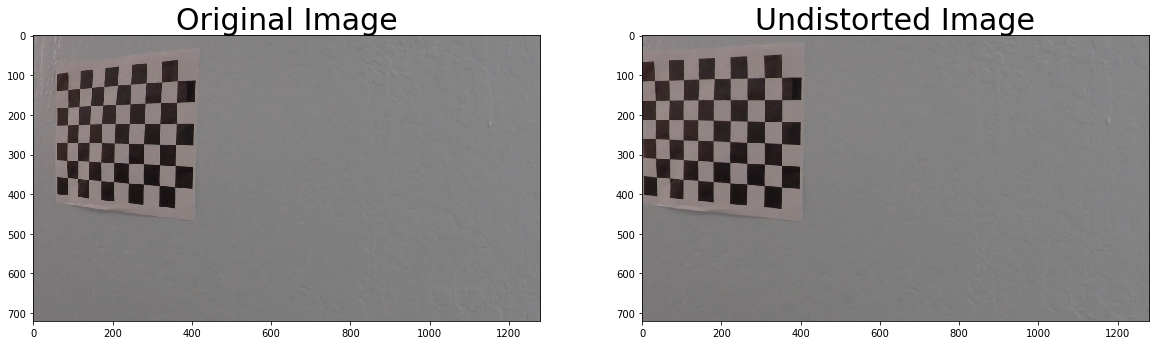

In [32]:
cam = Camera()
cam.load_calibration()

# Undistort image using camera matrix
img = cv2.imread('camera_cal/calibration19.jpg')
dst = cam.undistort_img(img);

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img), ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst), ax2.set_title('Undistorted Image', fontsize=30);

# 2. Pipeline (single images)

## Step 1: Camera correction

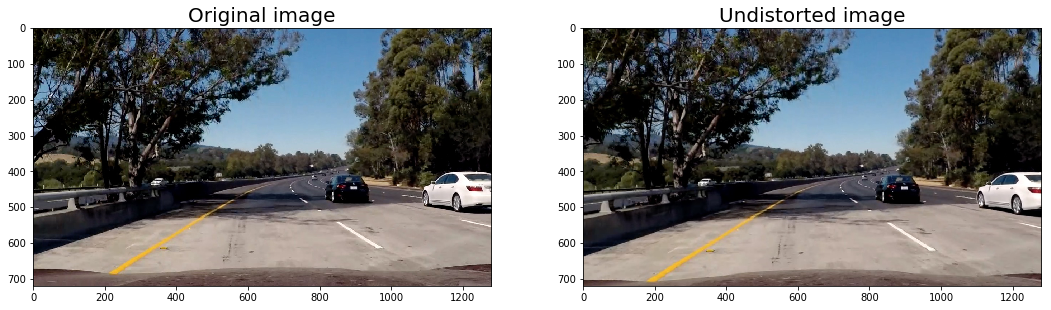

In [33]:
# Load and filter image
img = cv2.imread('color-shadow-example.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cam = Camera()
cam.load_calibration()
img_undist = cam.undistort_img(img);

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,9))
ax1.imshow(img), ax1.set_title('Original image', fontsize=20)
ax2.imshow(img_undist), ax2.set_title('Undistorted image', fontsize=20);
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## Step 2: Gradient detection

* blue = s_binary = threshold S channel
* grün = sxbinary = threshold sobel x on L channel

HIER FUNCTION BESCHREIBEN

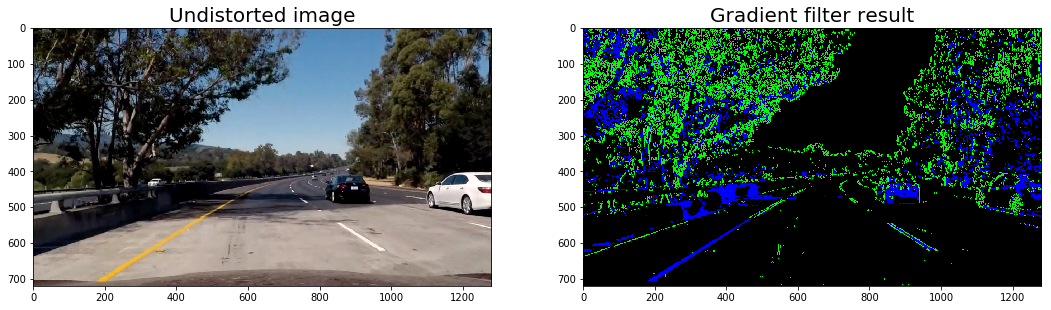

In [34]:
# Load and filter image
color_binary, result = ImageFilter.gradient_filter(img_undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
ax1.imshow(img_undist);  ax1.set_title('Undistorted image', fontsize=20)
ax2.imshow(color_binary); ax2.set_title('Gradient filter result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.show()

## Step 3: Perspective Trasformation

-- ! [alt text](./test_images/straight_lines1.jpg "Logo Title Text 1")

USA Lane width: 3.7 m (12ft)
The finding holds implications for traffic safety. Each dashed line measures 10 feet, and the empty spaces in-between measure 30 feet.

119         offset_x = 30 # offset for dst points
120         offset_y = -30
121         factor = 5

`src = [[308,648],[1000,648],[579,460],[703,460]]`

```
129         Lane_W = factor*(12) # ft (lande width)
130         Lane_D = factor*(30+10+30+10) # ft (lane distance)
```

```
140         dst = np.float32([[offset_x,        img_size[1]+offset_y],
141                           [Lane_W+offset_x, img_size[1]+offset_y],
142                           [offset_x,        img_size[1]-Lane_D+offset_y],
143                           [Lane_W+offset_x, img_size[1]-Lane_D+offset_y]])
```

####3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warper()`, which appears in lines 1 through 8 in the file `example.py` (output_images/examples/example.py) (or, for example, in the 3rd code cell of the IPython notebook).  The `warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

![alt text][image4]


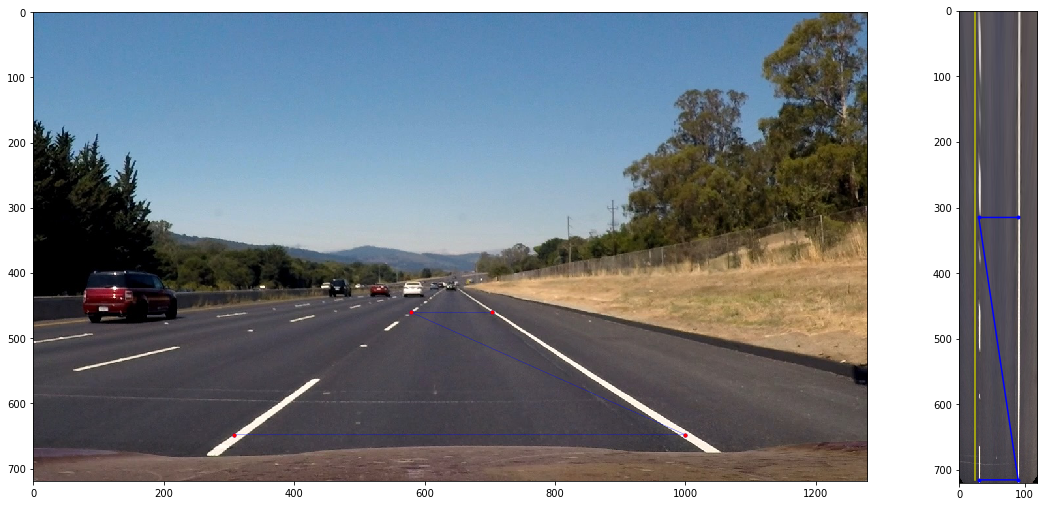

In [101]:
#importlib.reload(lib.camera)
#from lib.camera import Camera
cam = Camera()
cam.load_calibration()

# Load image and warp
image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_warp = cam.warp_birdeye(image)

fig = plt.figure(figsize=(18, 9)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[10.6, 1]) 
ax0 = plt.subplot(gs[0])
ax0.imshow(image)
ax0.plot(cam.src[:,0],cam.src[:,1],'b.-', linewidth=0.3)
for i in range(4): ax0.plot(cam.src[i,0],cam.src[i,1],'r.')

ax1 = plt.subplot(gs[1])
ax1.imshow(image_warp[0:,:,:])
ax1.plot(cam.dst[:,0],cam.dst[:,1],'b.-')
ax1.plot([25,25],[0,715], 'y-')
plt.show()

In [110]:
importlib.reload(lib.lane_detector)
importlib.reload(lib.lane_line)
from lib.lane_detector import LaneDetector
from lib.lane_line import LaneLine

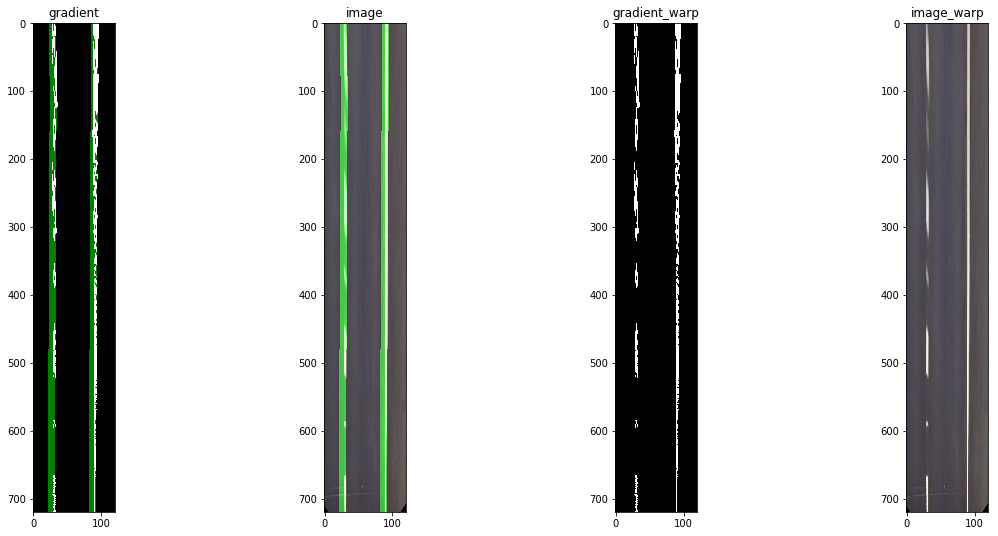

In [111]:
ld = LaneDetector()
_, window_centroids, images = ld.pipeline(cam, ImageFilter, image)
  
# Display the final results
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 9))
ax1.imshow(images['gradient']);                  ax1.set_title('gradient')
ax2.imshow(images['image']);                     ax2.set_title('image')
ax3.imshow(images['gradient_warp'],cmap='gray'); ax3.set_title('gradient_warp')
ax4.imshow(images['image_warp']);                ax4.set_title('image_warp')
plt.show()    

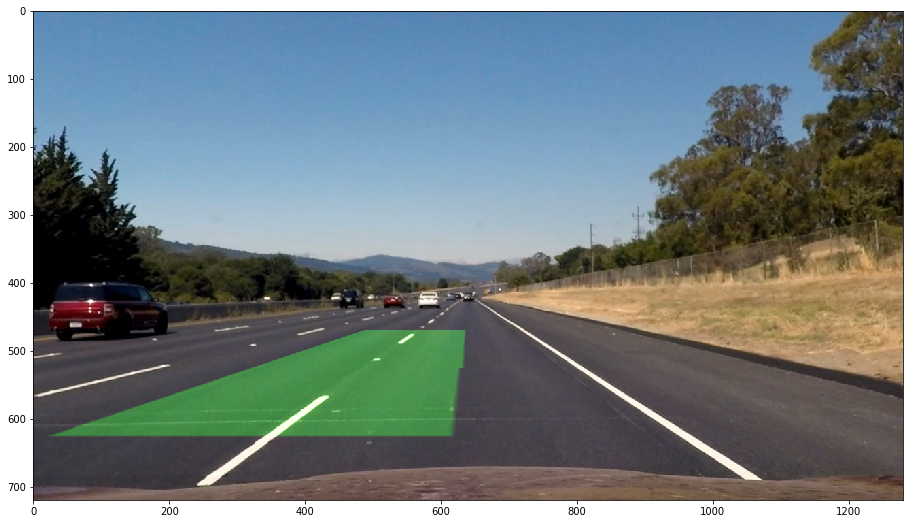

In [112]:
# Display the final results
plt.figure(figsize=(20, 9))
plt.imshow(images['final']);
#plt.gca.set_title('gradient')

####2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)

![alt text][image3]


####4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

![alt text][image5]

####5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in lines # through # in my code in `my_other_file.py`

####6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![alt text][image6]

# 3. Pipeline (video)

Final result on `project_video.mp4` looks like:

In [ ]:
from IPython.display import HTML
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format('project_video_lane_detection.mp4'))

Alternative: [link to video result](./project_video_lane_detection.mp4)

# 4. Discussion

####1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  
